# Выделение групп пользователей на основе  их поведения в мобильном приложении по продаже ненужных вещей

Цель: выделить сегменты пользователей, которые различаются по поведению в приложении для его улучшения с точки зрения пользовательского опыта.

# Материалы
* [Презентация](https://drive.google.com/file/d/1vv5jzJ2lfSe2hhmWIEJ9kEvSIRDeZQ3M/view?usp=drive_link)
* [Дашборд Набор №2](https://public.tableau.com/views/FinalProjectDash_16874341215970/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

Декомпозиция исследования:

1.  [Открытие данных](#h1)
2.  [Предобработка данных](#h2)
    * [Переименование колонок](#h21)
    * [Обработка дубликатов](#h22)
    * [Обработка пропущенных значений](#h23)
    * [Корректировка типов данных](#h24)
3. [Расчет и визуализация метрик](#h3)
    * [Retention rate](#h31)
    * [Время в приложении](#h32)
        * [Выделение сессий пользователей](h#321)
        * [Рассчет среднего времени сессии](h#322)
    * [Частота действий](#h33)
    * [Conversion Rate в просмотр контактов](#h34)
4. [Выделение сегментов и определение целевой группы](#h4)
    * [Выделение сегмента-лидера по retention rate](#h41)
    * [Выделение сегмента-лидера по conversion rate](#h42)
5. [Проверка гипотез](#h5)
    * [Проверить влияние источника трафика на конверсию в просмотры контактов](#h51)
    * [Проверить влияние повторного посещения приложения в течение 3 дней на конверсию в просмотры контактов](#h52)
6. [Заключение](#h6)

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

 <a id="h1"></a> 
 ## Открытие данных 


In [2]:
events=pd.read_csv('mobile_dataset.csv') #лог-файл
sources=pd.read_csv('mobile_sources.csv') #источники трафика

In [3]:
events.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


 <a id="h2"></a> 
 ## Предобработка данных

 <a id="h21"></a> 
 ### Переименование колонок

In [5]:
# Приведем названия колонок с snake_case
events.columns=['event_time','event_name','user_id']
sources.columns=['user_id','source']

 <a id="h22"></a> 
 ### Обработка дубликатов

In [6]:
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Contacts_show и show_contacts являются одним и тем же событием, объединим их

In [7]:
events.loc[events['event_name']=='show_contacts','event_name']='contacts_show'
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

In [8]:
sources['user_id'].duplicated().sum()

0

Дубликатов нет

 <a id="h23"></a> 
 ### Обработка пропущенных значений

In [9]:
events.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [10]:
sources.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [11]:
len(events['user_id'].unique())

4293

In [12]:
len(sources['user_id'].unique())

4293

In [13]:
len(pd.concat([events['user_id'],sources['user_id']]).unique()) 

4293

User_id  в обоих датавреймах совпадают

 <a id="h24"></a> 
 ### Корректировка типов данных

Скорректировать необходимо только переменную, отвечающую за время события.

In [16]:
events['event_time']= pd.to_datetime(
    events['event_time'], format='%Y-%m-%d %H:%M:%S')
'''.dt.strftime('%Y-%m-%d %H:%M')
events['event_time']= pd.to_datetime(
    events['event_time'], format='%Y-%m-%d %H:%M:%S')'''

".dt.strftime('%Y-%m-%d %H:%M')\nevents['event_time']= pd.to_datetime(\n    events['event_time'], format='%Y-%m-%d %H:%M:%S')"

In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


<div class="alert alert-info"> Исходные данные хорошего качества: пропусков нет, дубликаты есть только в переменной event_name (но это легко поправимо), набор user_id в обоих датасетах одинаковый.</div>

 <a id="h3"></a> 
 ## Расчет и визуализация метрик

 <a id="h31"></a> 
 ### Retention rate

In [18]:
events['event_time'].agg({'max':'max','min':'min'})

max   2019-11-03 23:58:00
min   2019-10-07 00:00:00
Name: event_time, dtype: datetime64[ns]

Так мы имеем данные всего за месяц, информативнее смотреть удержание с гранульностью - день, а не неделя. Для удобства добавим столбец с датой.

In [19]:
events['event_dt']=events['event_time'].dt.date
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_dt    74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


Также добавим столбец с датой первой сессии.

In [20]:
events=events.merge(events.groupby('user_id')['event_dt'].min().reset_index().rename(columns={'event_dt':'first_dt'}),on='user_id')
events.head()


,event_time,event_name,user_id,event_dt,first_dt
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
1,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
2,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
3,2019-10-07 00:01:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
4,2019-10-07 00:01:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07


In [21]:
#скорректируем тип данных у дат
events['event_dt']=pd.to_datetime(events['event_dt'],format='%Y-%m-%d')
events['first_dt']=pd.to_datetime(events['first_dt'],format='%Y-%m-%d')
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_dt    74197 non-null  datetime64[ns]
 4   first_dt    74197 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(2)
memory usage: 3.4+ MB


In [22]:
#Добавим lifetime
events['lifetime']=(events['event_dt']-events['first_dt']).dt.days

In [23]:
#уберем время
events['event_dt']=events['event_dt'].dt.date
events['first_dt']=events['first_dt'].dt.date

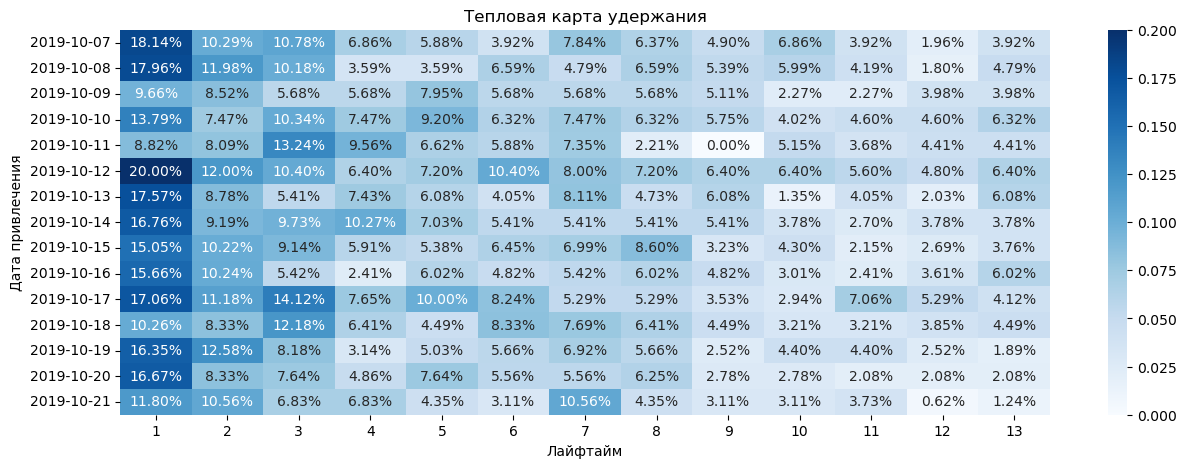

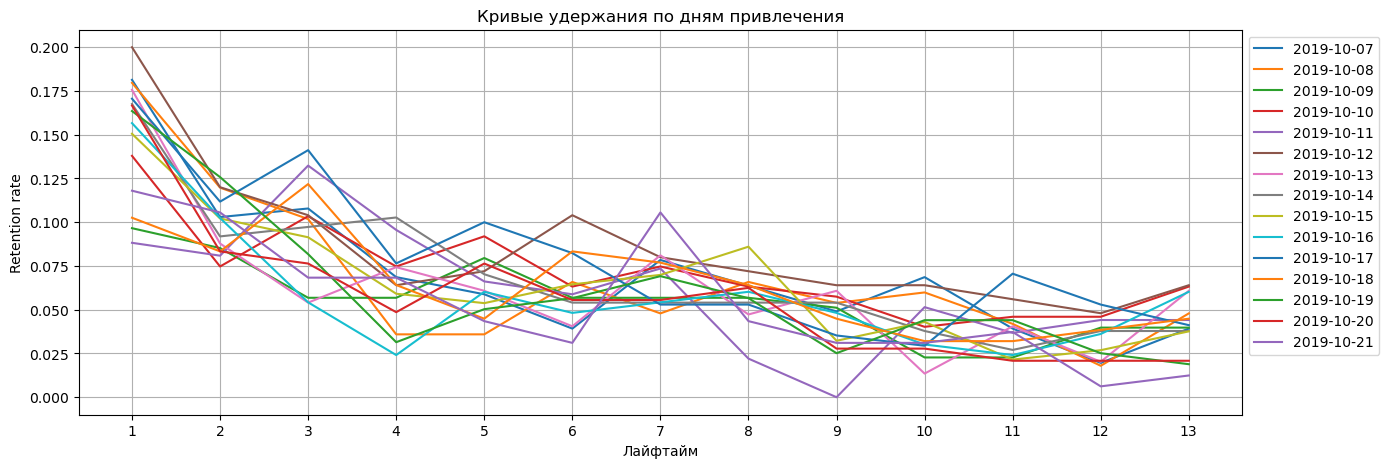

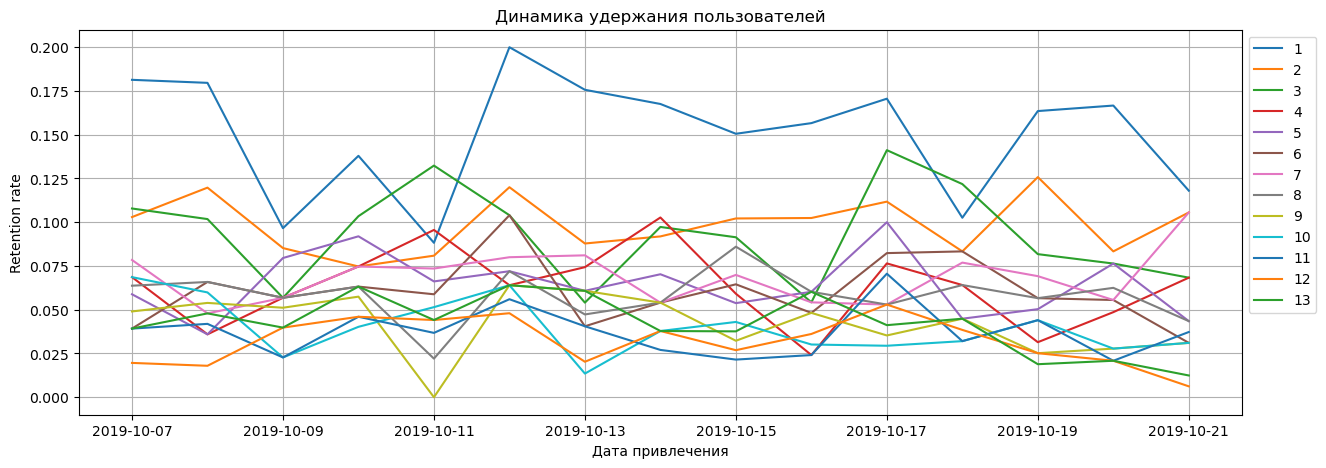

In [25]:
#Добавим функции для расчета и визуализации удержания, чтобы смотреть в разных сегментах и для разного горизонта анализа
def retention(df,observation_date= events['event_dt'].max(),horizon_days = 14,dim='first_dt'):
    "Эта функция строит таблицу удержания на момент observation_date с горизонтом horizon_days и в разрезе dim"
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    retention_raw=df.query('first_dt <= @last_suitable_acquisition_date')
    
    #строим таблицу удержания
    retention_grouped=retention_raw.pivot_table(index=[dim],columns='lifetime',values='user_id',aggfunc='nunique')
    
    #Добавляем размер когорт
    cohort_size=retention_raw.groupby(dim).agg({'user_id':'nunique'}).rename(columns={'user_id': 'cohort_size'})
    retention_grouped=cohort_size.merge(retention_grouped,on=dim,how='left')
    retention_grouped=retention_grouped.fillna(0).div(retention_grouped['cohort_size'],axis=0)
    
    #Убираем все лайфтаймы, превышающие горизонт анализа
    retention_grouped=retention_grouped[['cohort_size']+list(range(horizon_days))]
    retention_grouped['cohort_size']=cohort_size
    return     retention_grouped

def plots(ret,x='удержания'):
    "Эта функция строит 3 графика для удержания или конверсии"
    #строим хитмэп
    plt.figure(figsize=(15,5))
    sns.heatmap(ret.drop(columns=['cohort_size',0]),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Лайфтайм')
    plt.ylabel('Дата привлечения')
    plt.title(f'Тепловая карта {x}')  
    plt.show()
    
    report = ret.drop(columns = ['cohort_size', 0])
    #Строим кривые удержания
    report.T.plot(
    grid=True, 
    xticks=list(report.columns.values),  
    figsize=(15, 5))
    if x=='удержания':
        plt.ylabel('Retention rate')
    else: 
        plt.ylabel('Conversion rate')
    plt.xlabel('Лайфтайм') 
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.title(f'Кривые {x} по дням привлечения') 
    plt.show()
                      
    #Строим график изменения удержания или конверсии 
    report.plot(grid=True, figsize=(15, 5))
    if x=='удержания':
        plt.ylabel('Retention rate')
    else: 
        plt.ylabel('Conversion rate')
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика {x} пользователей')
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
plots(retention(events))


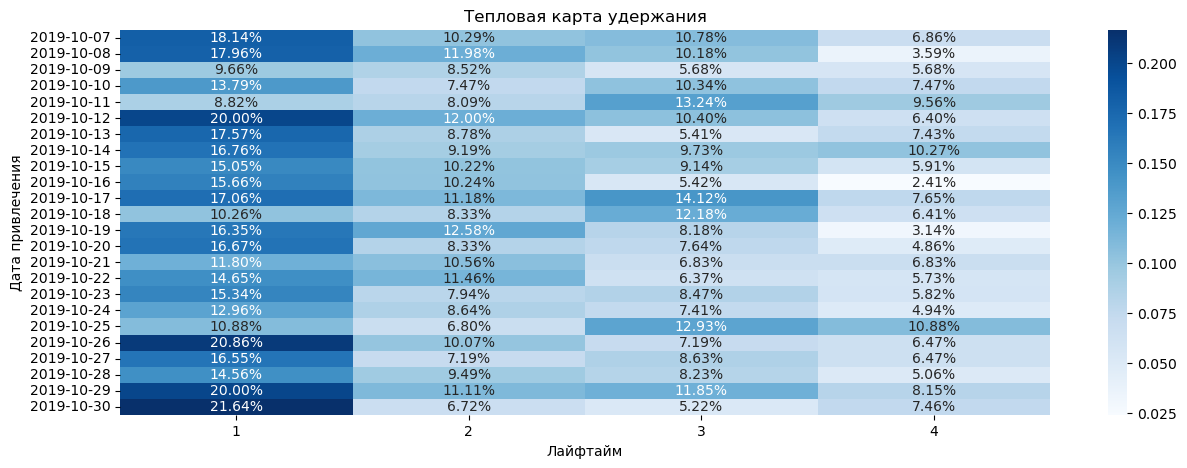

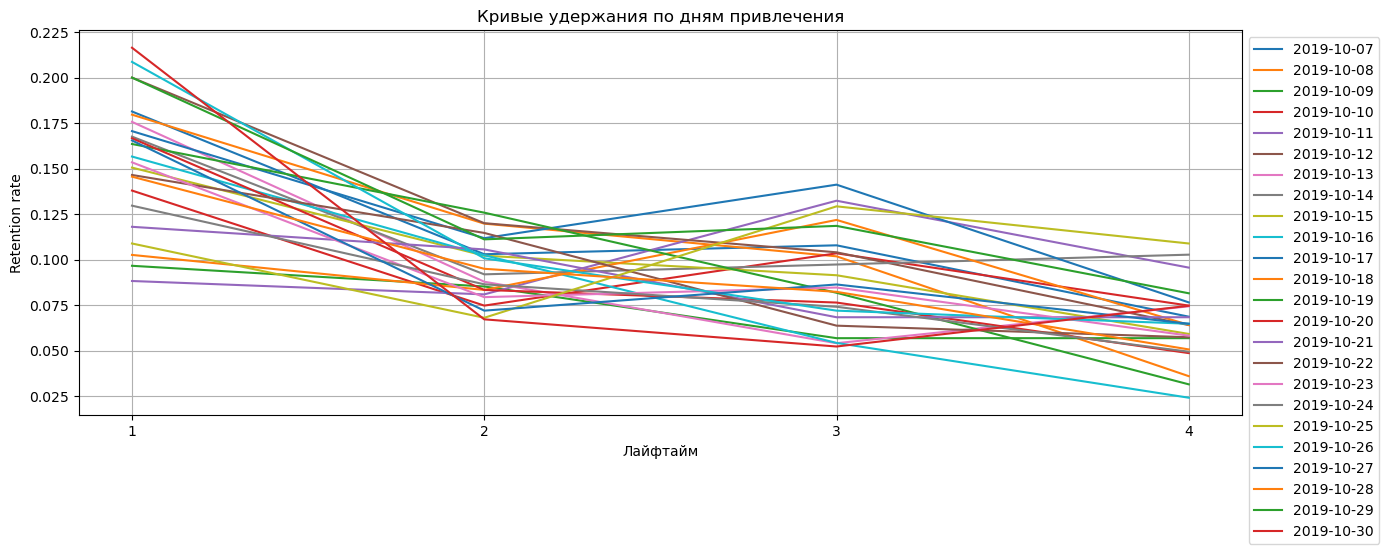

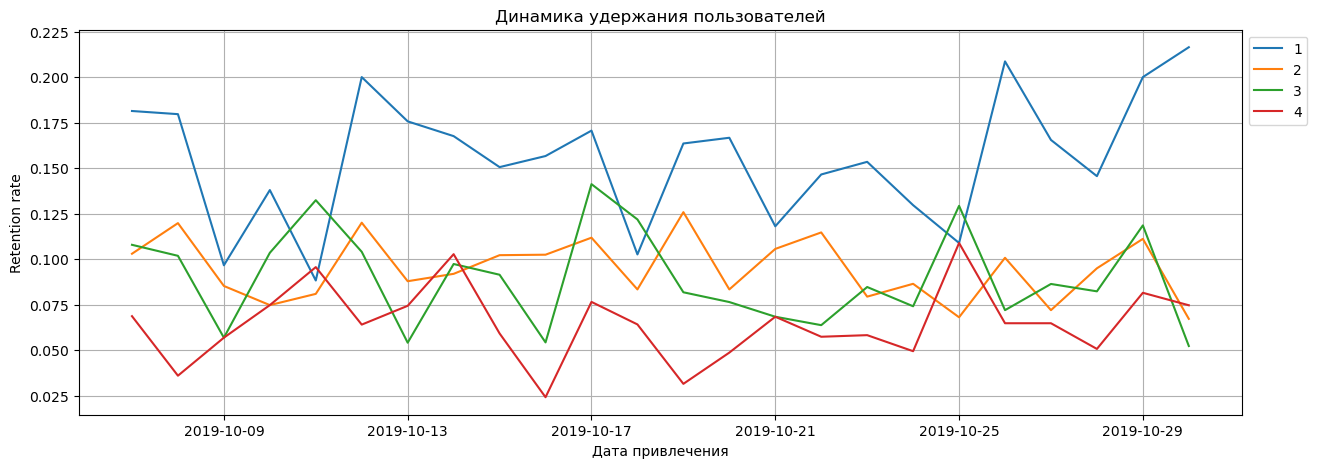

In [26]:
plots(retention(events,horizon_days=5))

Можно заметить, что по субботам пользоавтели заходят в приложение редко. Проще всего это увидеть по удержанию первого дня: 11-ого, 18-ого и 25-ого (все это пятницы) retention rate 1-ого дня один из самых низких среди когорт. А по воскресеньям, наоборот: удержание первого дня 12-ого и 26-ого одно из самых высоких.

 <a id="h32"></a> 
 ### Время в приложении

 <a id="h321"></a> 
 #### Выделение сессий пользователей

Для расчета среднего времени сессии их нужно выделить. Будем считать, что события составляют одну сессию, если они происходили с перерывом меньше, чем 40 минут.

В целом по графикам видно, что временная разница между событиями крайне редко превышает 30-40 мин, потэтому 40 минут кажется оптимальной продолжительностью сессии.

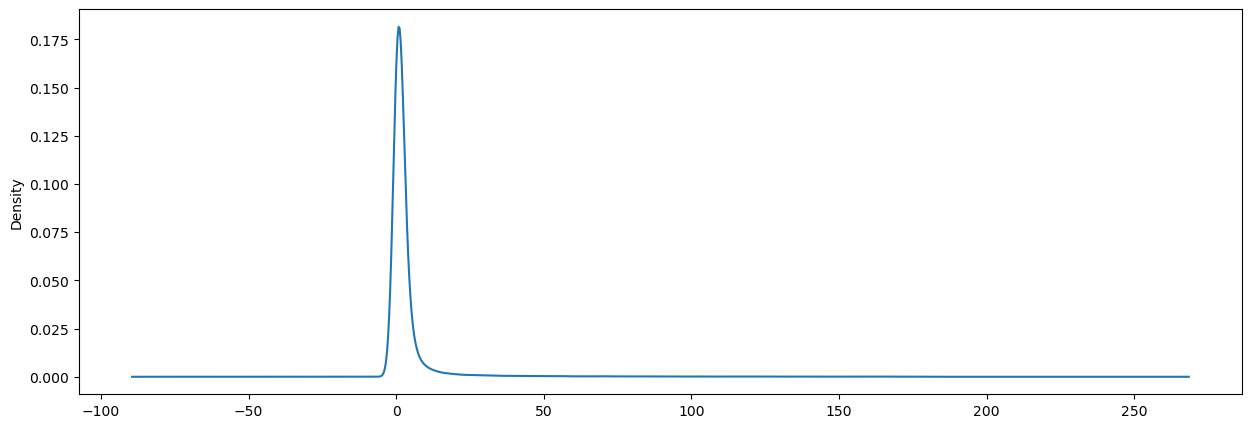

In [31]:
plt.figure(figsize=(15,5))
diff_time=(events.sort_values(by=['user_id','event_time'],ascending=True).groupby('user_id')['event_time'].diff().
         dt.total_seconds()/60)
diff_time[diff_time<180].plot.density()
plt.show()

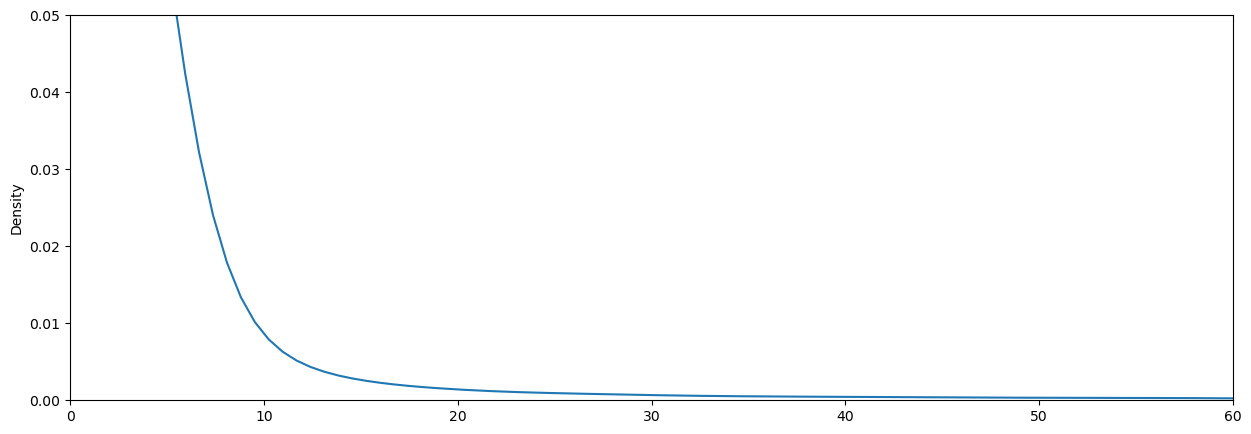

In [32]:
plt.figure(figsize=(15,5))
diff_time=(events.sort_values(by=['user_id','event_time'],ascending=True).groupby('user_id')['event_time'].diff().
         dt.total_seconds()/60)
diff_time[diff_time<360].plot.density()
plt.xlim([0,60])
plt.ylim([0,0.05])
plt.show()

In [36]:
g = (events.sort_values(by=['user_id','event_time'],ascending=True)
      .groupby('user_id')['event_time'].diff()>= '40Min').cumsum()

In [38]:
events['session']=events.groupby(['user_id',g],sort=False).ngroup()+1

In [39]:
events.head()

,event_time,event_name,user_id,event_dt,first_dt,lifetime,session
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1
1,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1
2,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1
3,2019-10-07 00:01:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1
4,2019-10-07 00:01:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1


 <a id="h322"></a> 
 #### Рассчет среднего времени сессии

In [40]:
sessions=events.groupby('session').agg({'user_id':'first','event_time':['min','max'],'event_name':['first','last']})
sessions.columns=['user_id','start','end','first_event','last_event']
sessions['duration']=(sessions['end']-sessions['start']).dt.total_seconds() / 60
sessions

,user_id,start,end,first_event,last_event,duration
session,,,,,,
1,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,2019-10-07 00:18:00,advert_open,tips_show,18.0
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:00,2019-10-07 00:41:00,tips_show,tips_show,41.0
3,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-08 20:06:00,2019-10-08 20:19:00,advert_open,tips_show,13.0
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-10 19:43:00,2019-10-10 20:12:00,tips_show,tips_show,29.0
5,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-16 21:17:00,2019-10-16 22:02:00,tips_show,tips_show,45.0
...,...,...,...,...,...,...
10038,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,2019-11-03 23:10:00,2019-11-03 23:24:00,photos_show,photos_show,14.0
10039,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,2019-11-03 23:22:00,2019-11-03 23:45:00,tips_show,tips_show,23.0
10040,437a4cd4-9ba9-457f-8614-d142bc48fbeb,2019-11-03 23:44:00,2019-11-03 23:45:00,tips_show,tips_show,1.0


In [41]:
sessions['duration'].describe()

count    10042.000000
mean        14.417347
std         23.097577
min          0.000000
25%          1.000000
50%          6.000000
75%         19.000000
max        367.000000
Name: duration, dtype: float64

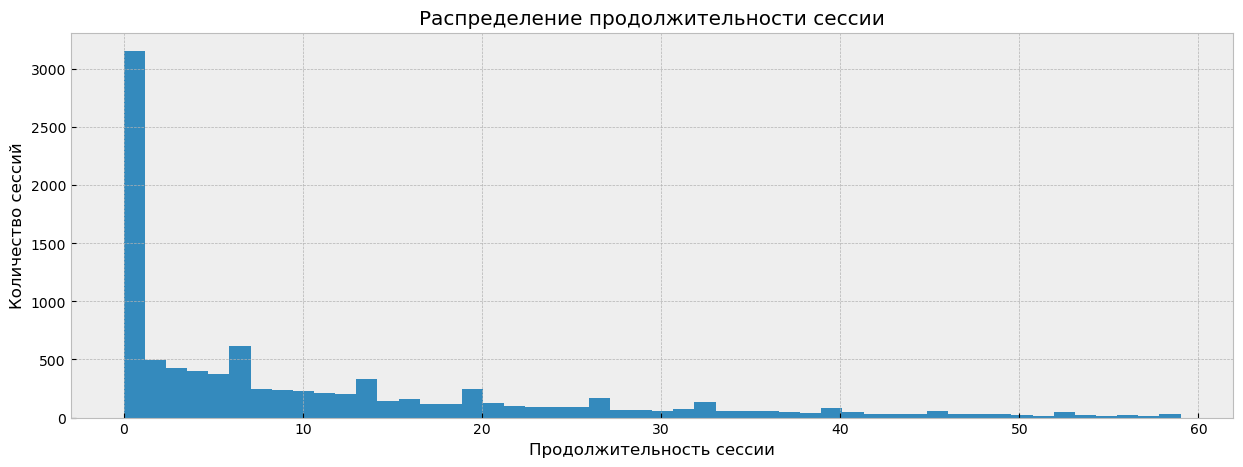

In [42]:
plt.style.use('bmh')
plt.figure(figsize=(15,5))
plt.hist(sessions[sessions['duration']<60]['duration'],bins=50)
plt.title('Распределение продолжительности сессии')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Количество сессий')
plt.show()

Очень много сессий с нулевой продолжительностью (25%). Другими словами, пользователи часто совершают в нашем приложении только 1 действие.

In [43]:
len(sessions[sessions['duration']==0])/len(sessions)

0.2483569010157339

In [44]:
len(sessions[sessions['duration']==0]['user_id'].unique())/len(sessions['user_id'].unique())

0.29000698812019565

In [45]:
zero=pd.DataFrame(sessions[sessions['duration']==0]['first_event'].value_counts()).reset_index().rename(columns={'index':'event_name'})


In [46]:
zero=zero.merge(pd.DataFrame(events.groupby('event_name')['user_id'].count()).reset_index())
zero['0_share']=zero['first_event']/zero['user_id']
zero.columns=['event','0_sessions','all_sessions','0_share']
zero.sort_values(by='0_share')

,event,0_sessions,all_sessions,0_share
5,advert_open,86,6164,0.013952
13,search_3,8,522,0.015326
12,tips_click,14,814,0.017199
0,tips_show,933,40055,0.023293
7,favorites_add,35,1417,0.024700
9,search_5,29,1049,0.027645
4,map,114,3881,0.029374
10,search_6,15,460,0.032609
3,contacts_show,191,4529,0.042173
11,search_2,15,324,0.046296


Больше всего доля пользователей с 0 продолжителньостью сессии среди событий search_1 и search_7, далее идет просмотр фотографий товара (6%).
Замечу, что довольно много нулевых сессий, где пользователь просматривает контакты. Скорее всего, пользователи уже раньше просматривали товар, оставили открытой страницу приложения и спустя какое-то время приняли решение вернуться и купить его. Из-за временного лага события по поиску и выбору товара, с одной стороны, и по просмотру контактов, с дургой, разбиты на разные сессии.

Посмотрим на удержание пользователей, имеющих нулевые сессии

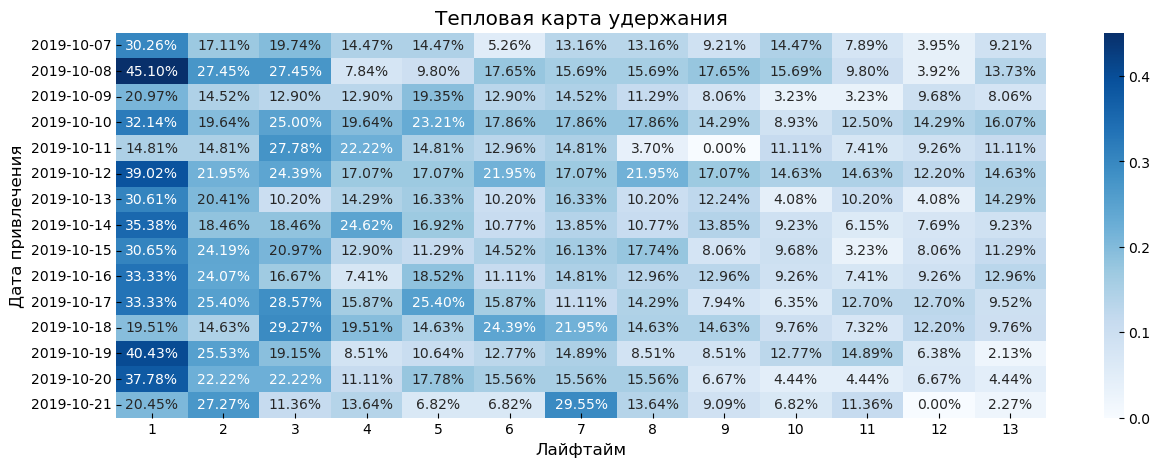

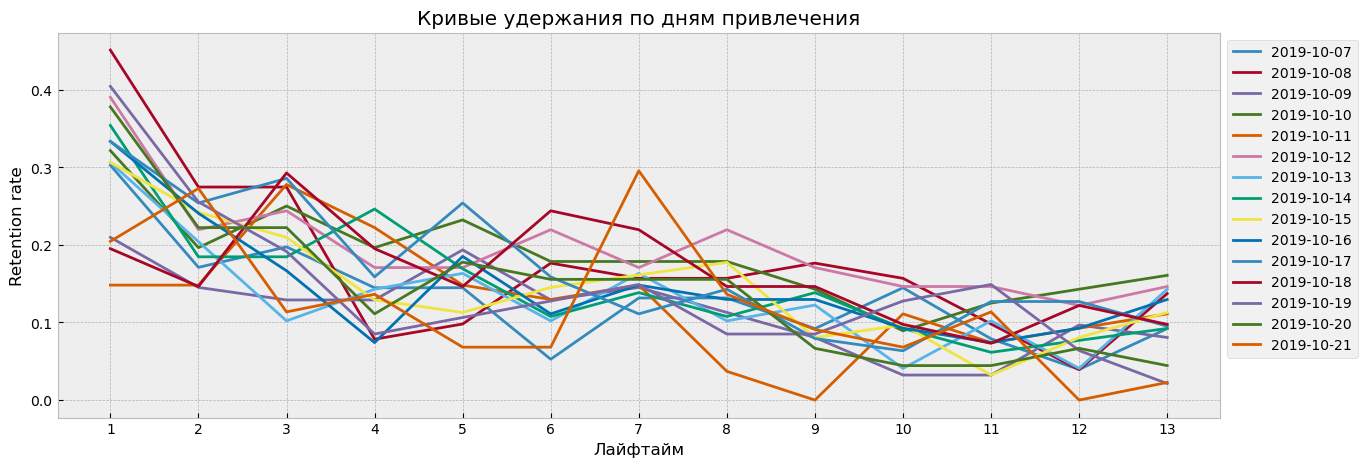

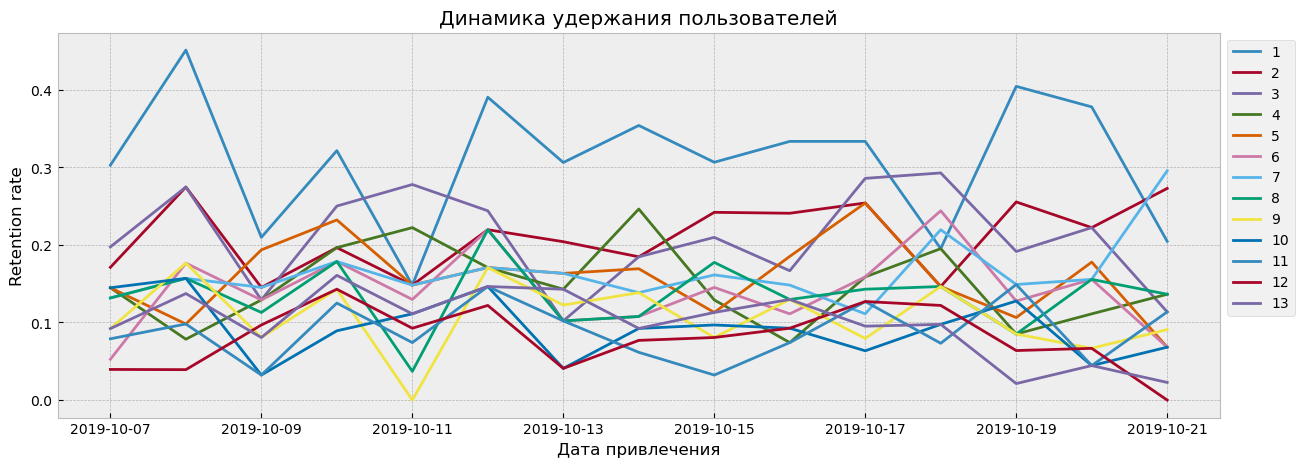

In [47]:

plots(retention(events[(events['user_id']).isin(sessions[sessions['duration']==0]['user_id'].unique())]))


У данных пользователей удержание довольно высокое, выше, чем в целом по выборке. Это значит, что пользователям нужно время для размышлений для совершений покупки. Возможно, для увеличения оборачиваемости и продаж в целом необходим наджинг в виде  скидок/бесплатной доставки/бонусов при покупке в течение часа. Так можно воздействовать на "нерешительных пользователей".

Вернемся к ненулевым сессиям.

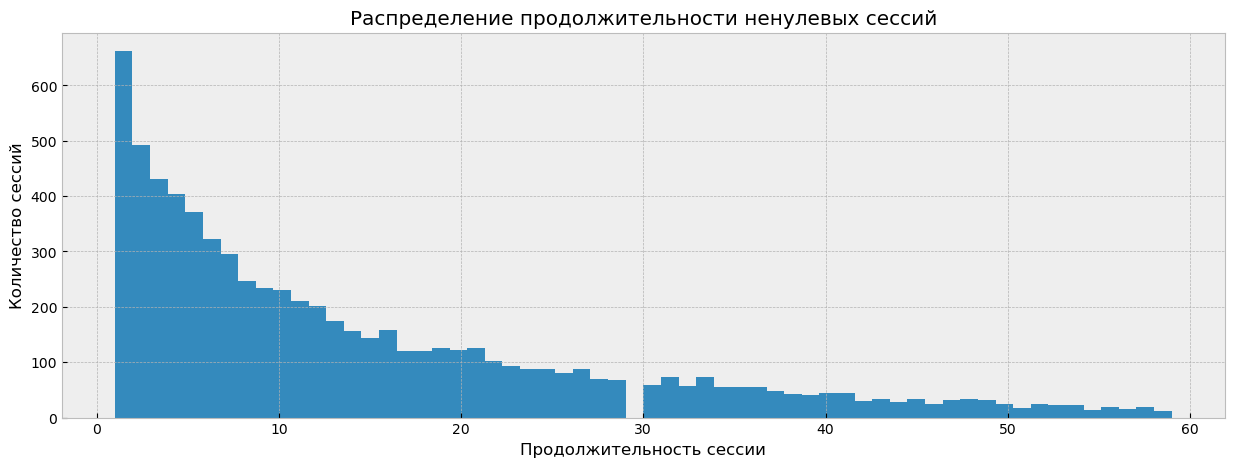

In [48]:
plt.figure(figsize=(15,5))
plt.hist(sessions[(sessions['duration']<60)&(sessions['duration']>0)]['duration'],bins=60)
plt.title('Распределение продолжительности ненулевых сессий')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Количество сессий')
plt.show()

Все равно очень много околнулевых сессий

In [49]:
sessions[sessions['duration']>0]['duration'].describe()

count    7548.000000
mean       19.181108
std        24.867907
min         1.000000
25%         4.000000
50%        11.000000
75%        25.000000
max       367.000000
Name: duration, dtype: float64

Среднее время сессии (19 мин) практически в два раза больше медианного (11 мин), что говорит о больших выбросах и скошенности графика вправо.
Посмотрим на среднее время сессий, в которых было совершено целевое действие - просмотр контактов.

In [50]:
target_sessions=events[events['event_name']=='contacts_show']['session'].unique()
sessions[(sessions.index.isin(target_sessions))&(sessions['duration']>0)]['duration'].describe()

count    1441.000000
mean       26.426093
std        31.175360
min         1.000000
25%         6.000000
50%        16.000000
75%        36.000000
max       277.000000
Name: duration, dtype: float64

Ненулевые сессии, в которых было совершено целевое действие, более длинные: медиана 16 мин, среднее 26 мин.

In [51]:
events.merge(sessions,on='session',how='left').groupby('event_name').agg({'duration':['mean','min','max','nunique']})

duration                    
                    mean  min    max nunique
event_name                                  
advert_open    39.721285  0.0  367.0     116
contacts_call  20.630314  0.0   99.0      59
contacts_show  42.338265  0.0  277.0     129
favorites_add  53.030346  0.0  367.0      93
map            40.282401  0.0  367.0     135
photos_show    23.042749  0.0  208.0     100
search_1       18.467199  0.0  208.0      86
search_2       18.413580  0.0  166.0      68
search_3       27.867816  0.0  367.0      81
search_4       19.015692  0.0  182.0      87
search_5       18.088656  0.0  208.0     100
search_6       15.321739  0.0  198.0      61
search_7       17.049550  0.0  205.0      56
tips_click     39.578624  0.0  235.0     101
tips_show      43.050331  0.0  367.0     160

Самые короткие сессии - сессии с поиском. Самые длинные - с добавлением товара в избранное (сразу понятно, что пользователь настроен вернуться в товару через время).

 <a id="h33"></a> 
 ### Частота действий

In [52]:
freq=events.groupby('event_name').agg({'session':['count','nunique'],'user_id':'nunique'})
freq.columns=['total','sessions','users']
freq['per_sess']=freq['total']/freq['sessions']

In [53]:
freq=freq.reset_index().sort_values(by='per_sess',ascending=False)
freq

,event_name,total,sessions,users,per_sess
14,tips_show,40055,5833,2801,6.866964
0,advert_open,6164,1228,751,5.019544
5,photos_show,10012,2465,1095,4.061663
3,favorites_add,1417,496,351,2.856855
2,contacts_show,4529,1670,981,2.711976
6,search_1,3506,1619,787,2.165534
13,tips_click,814,413,322,1.970944
4,map,3881,2115,1456,1.834988
8,search_3,522,295,208,1.769492
1,contacts_call,541,308,213,1.756494


Интерестно, что в среднем за сессию пользователь открывает карточку объявления 5 раз, а переходит по рекомендованному лишь 2 раза. То есть 3 из 5 раза пользователь переходит на карточку целенаправленно, рекомендации его не так заинтересовывают. Возможно, стоит подумать об улучшении рекомендательных алгоритмов.

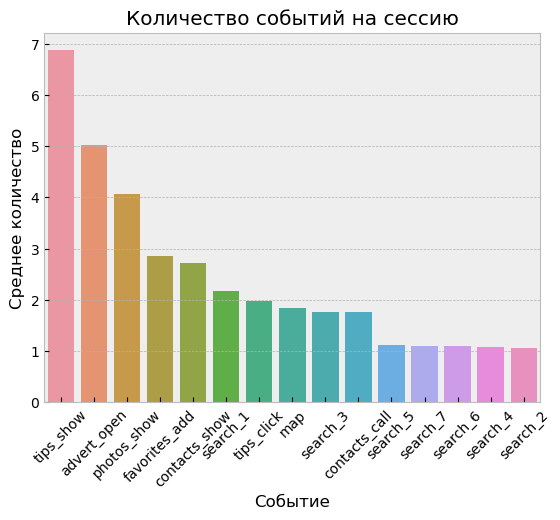

In [54]:
sns.barplot(x='event_name',y='per_sess',data=freq)
plt.xticks(rotation = 45) 
plt.title('Количество событий на сессию')
plt.xlabel('Событие')
plt.ylabel('Среднее количество')
plt.show()

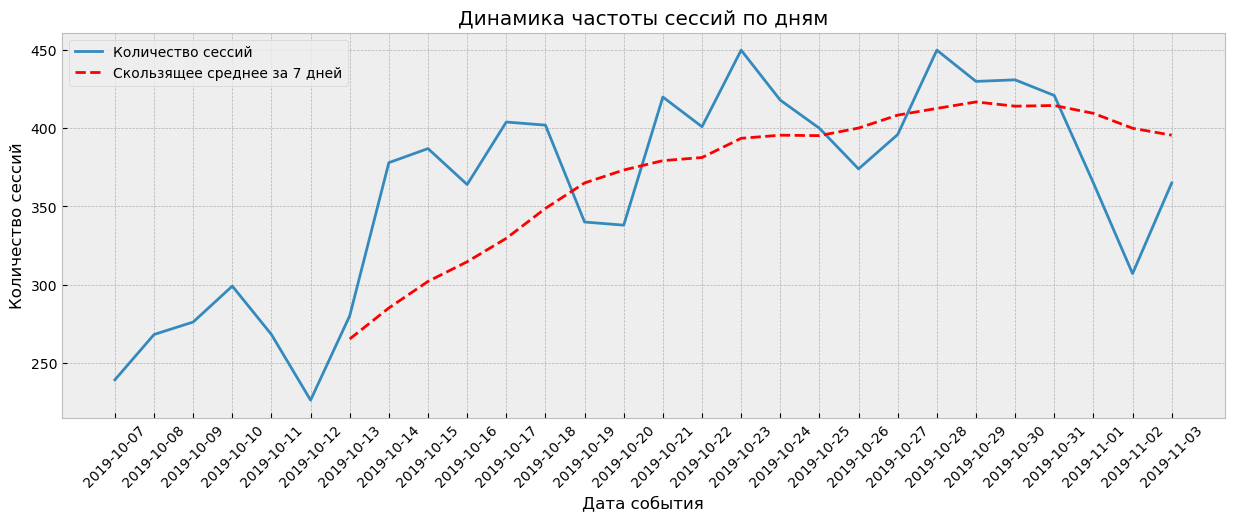

In [55]:
freq=events.groupby('event_dt').agg({'session':'nunique'})
freq['7day_rolling_avg'] = freq.session.rolling(7).mean()
plt.figure(figsize=[15,5])
sns.lineplot(x='event_dt',y='session',data=freq,label='Количество сессий')
sns.lineplot( x = 'event_dt',
             y = '7day_rolling_avg',
             data = freq,
             label = 'Скользящее среднее за 7 дней',color='r',linestyle='dashed')
plt.xlabel('Дата события')
plt.ylabel('Количество сессий')
plt.xticks(events['event_dt'].sort_values().unique(),rotation = 45)
plt.title('Динамика частоты сессий по дням')
plt.show()



Заметны выраженные провалы по субботам, как я уже ранее упоминала. Но явной цикличности в пиках нет.

 <a id="h34"></a> 
 ### Conversion rate

In [56]:
def conversion(df,observation_date= events['event_dt'].max(),horizon_days = 14,dim='first_dt'):
    "Эта функция рассчитывает конверсию по дням на момент observation_date с горизонтом horizon_days в разрезе dim"
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    conversion_raw=df.query('first_dt <= @last_suitable_acquisition_date')
    conversion_raw_final=conversion_raw.query('event_name=="contacts_show"')
    
    #строим таблицу конверсии
    conversion_grouped=conversion_raw_final.pivot_table(index=[dim],columns='lifetime',values='user_id',aggfunc='nunique')
    conversion_grouped=conversion_grouped.fillna(0).cumsum(axis=1)
    
    #Добавляем размер когорт
    cohort_size=conversion_raw.groupby(dim).agg({'user_id':'nunique'}).rename(columns={'user_id': 'cohort_size'})
    conversion_grouped=cohort_size.merge( conversion_grouped,on=dim,how='left')
    conversion_grouped= conversion_grouped.div(conversion_grouped['cohort_size'],axis=0)
    
    #Убираем все лайфтаймы, превышающие горизонт анализа
    conversion_grouped=conversion_grouped[['cohort_size']+list(range(horizon_days))]
    conversion_grouped['cohort_size']=cohort_size
    return     conversion_grouped

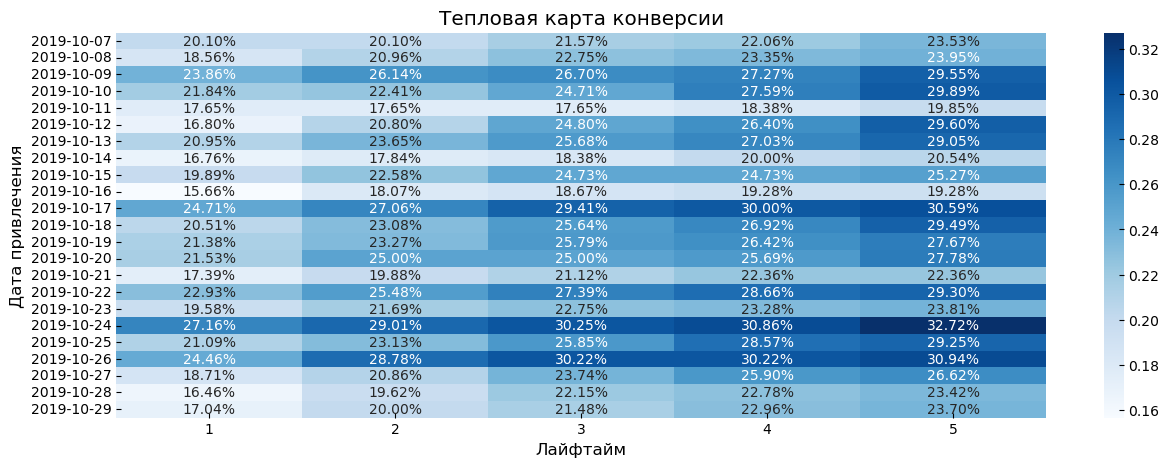

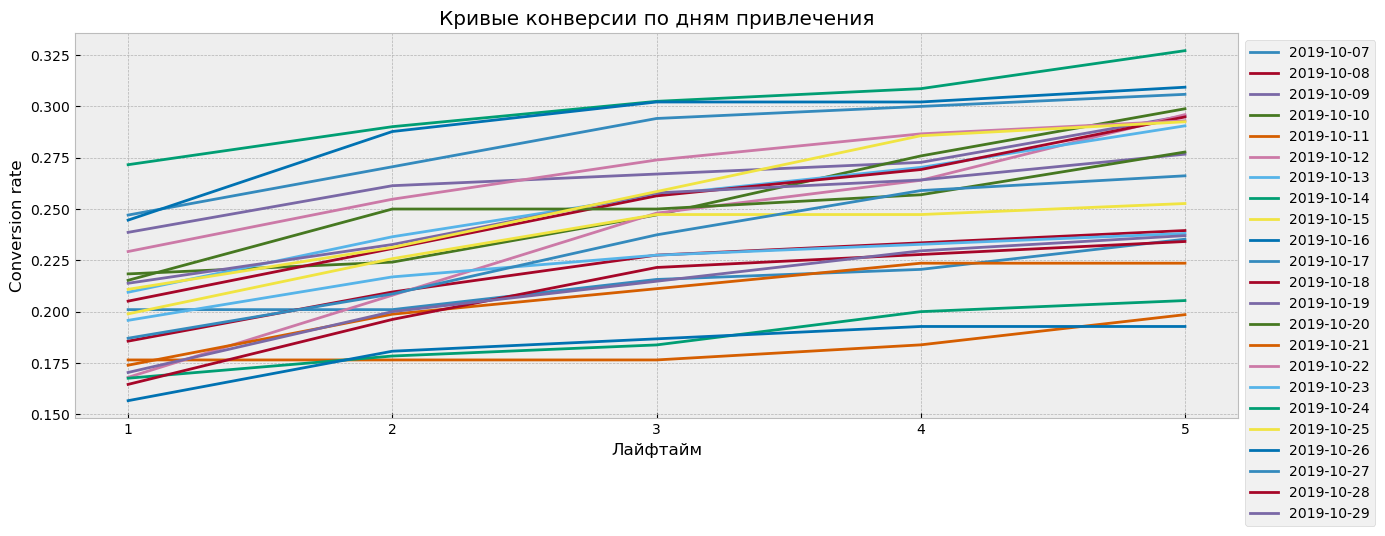

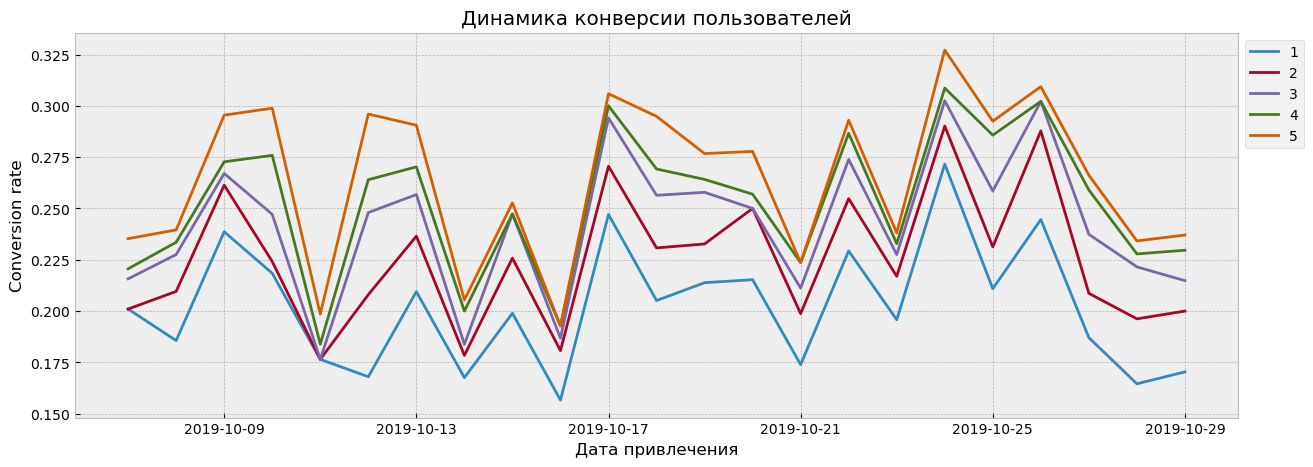

In [57]:
plots(conversion(events,horizon_days=6),'конверсии')

Конверсия очень отличается от когорты к когорте. В целом конверия 5-ого дня довольно высокая - около 25-30%.

In [58]:
round(len(events[events['event_name']=='contacts_show']['user_id'].unique())
      /len(events['user_id'].unique())*100,3)

22.851

 Общая конверсия по проекту составила 23%.

<div class="alert alert-info"> 
Итак, можно отметить некоторые отличительные черты пользователей мобильного приложения:
    
    
*    По субботам пользователи заходят в приложение редко: заметны явные провалы в количестве сессий. По воскресениям ситуация получше, но не сильно. 
    По пятницам же, наоборот: удержание первого дня у пользователей, впервые посиетивших приложение в пятницу, одно из самых высоких.

* В датасете около 25% всех сессий - это сессии с нулевой продолжительностью, то есть пользователи склонны совершать в приложении только 1 действие. У данных пользователей с такими сессиями удержание выше, чем в целом по выборке, что указывает на временной лаг между поиском товара и принятием решения о покупке. 

* Среднее время сессии (19 мин) практически в два раза больше медианного (11 мин), что говорит о больших выбросах и скошенность графика вправо. 
    
* В среднем за сессию пользователь открывает карточку объявления по продаже товара 5 раз, а переходит по рекомендованному лишь 2 раза, то есть 3 раза из 5 пользователь переходит на карточку целенаправленно, рекомендации не оказывают на него сильного влияния.
    
* Конверсия пользователей в просмотр контактов продавца сильно отличается от когорты к когорте. В целом по выборке она составляет около 23%.
</div>

 <a id="h4"></a> 
 ## Выделение сегментов

<div class="alert alert-info"> 
Интересно было бы посмотреть на различия в поведении пользователей в зависимости от источника трафика. 
    
Скорее всего люди, пришедшие по ссылке из поисковой выдачи, должны показать большую конверсию, так как они целенаправленно искали тот или иной товар. При этом удержание, вероятно, будет более низким, так как такие пользователи скорее всего были в поиске конкретного товара (они не были заинтересованы в нашем приложении) и вполне возможно, купив его, больше не зайдут в  приложение.
    
Что же касается пользователей из других источников (из рассылок/соц сетей и прямой трафик), то их поведение тоже будет показательно. Если их конверсия вдруг окажется выше, то это будет указанием на хорошее качество рекламной рассылки и продвижения приложения в соц сетях. 


Посмотрим на поведение пользователей в разрезе источников трафика.
Для этого объединим датасеты.

In [59]:
events=events.merge(sources,on='user_id')
events.head()

,event_time,event_name,user_id,event_dt,first_dt,lifetime,session,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1,other
1,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1,other
2,2019-10-07 00:00:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1,other
3,2019-10-07 00:01:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1,other
4,2019-10-07 00:01:00,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07,0,1,other


In [60]:
events['source'].value_counts() #разница в размере сегментов не очень большая

yandex    34286
google    20445
other     19466
Name: source, dtype: int64

 <a id="h41"></a> 
 ### Выделение сегмента-лидера по retention rate

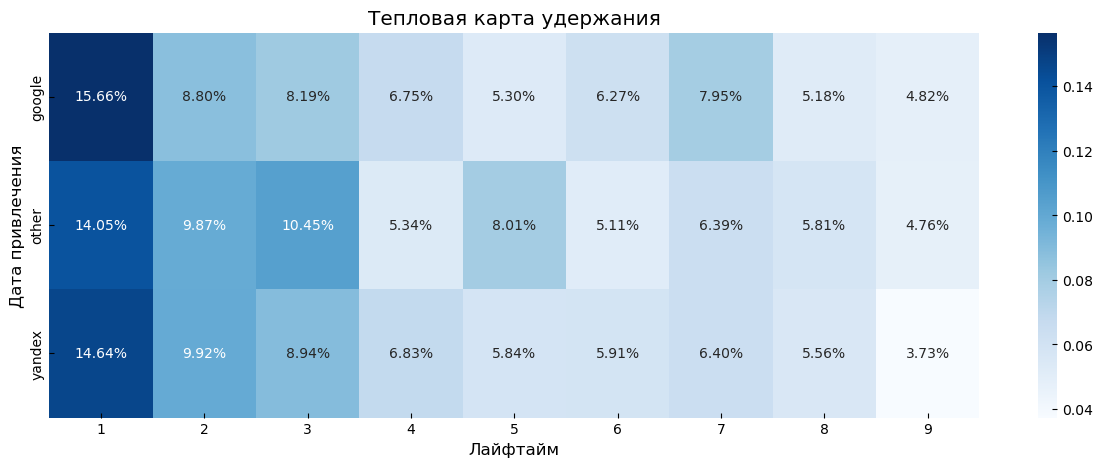

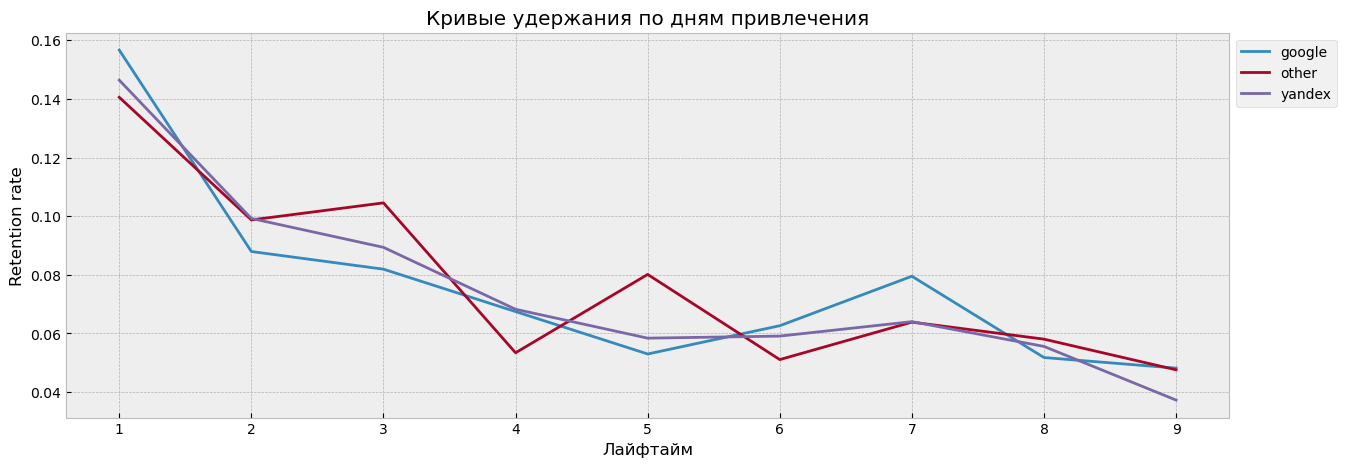

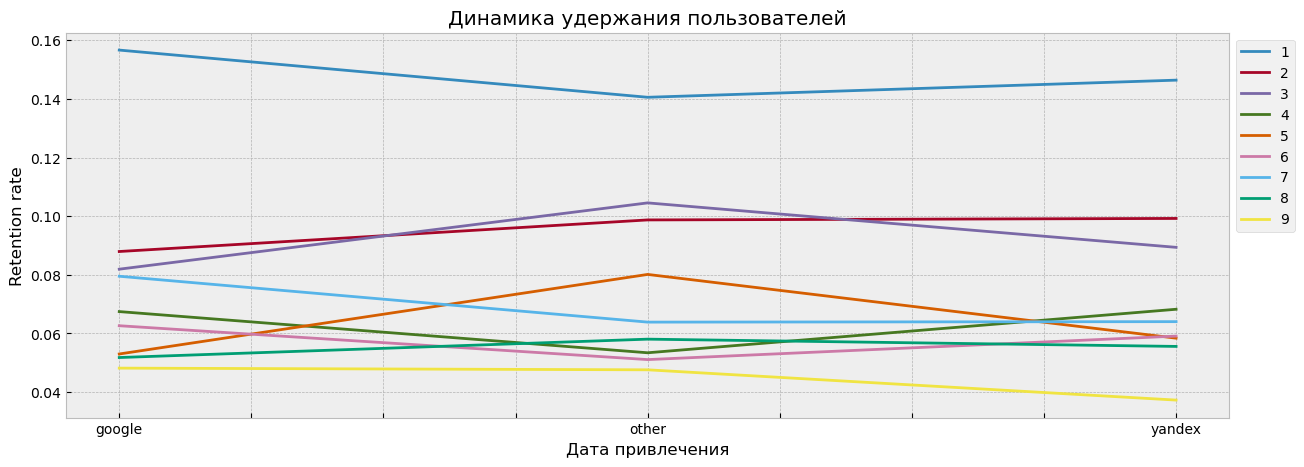

In [61]:
plots(retention(events,dim='source',horizon_days=10))

Однозначного лидера нет. В первый день у пользователей google удержание больше, чем из других источников, однако данная динамика нестабильна. Кривая удержания пользователей из google имеет более выраженные флуктуации, чем пользователи из yandex. Однако относительно пользователей из других источников ее можно считать монотонной. 

 <a id="h41"></a> 
 ### Выделение сегмента-лидера по conversion rate

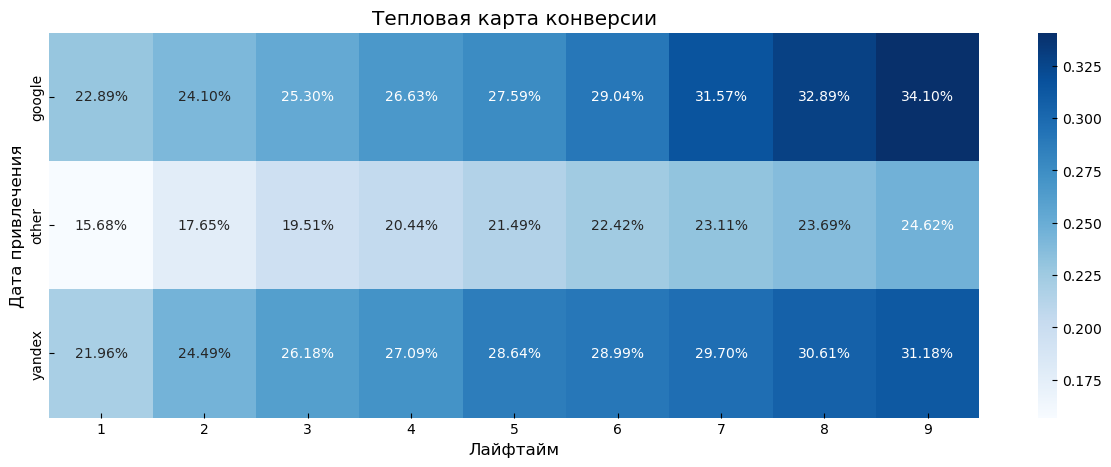

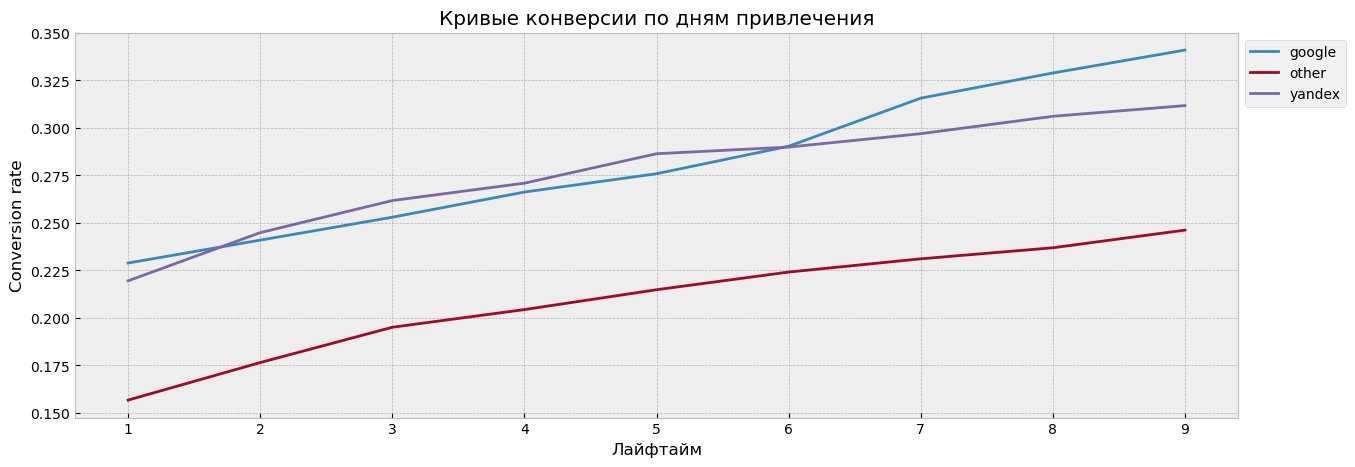

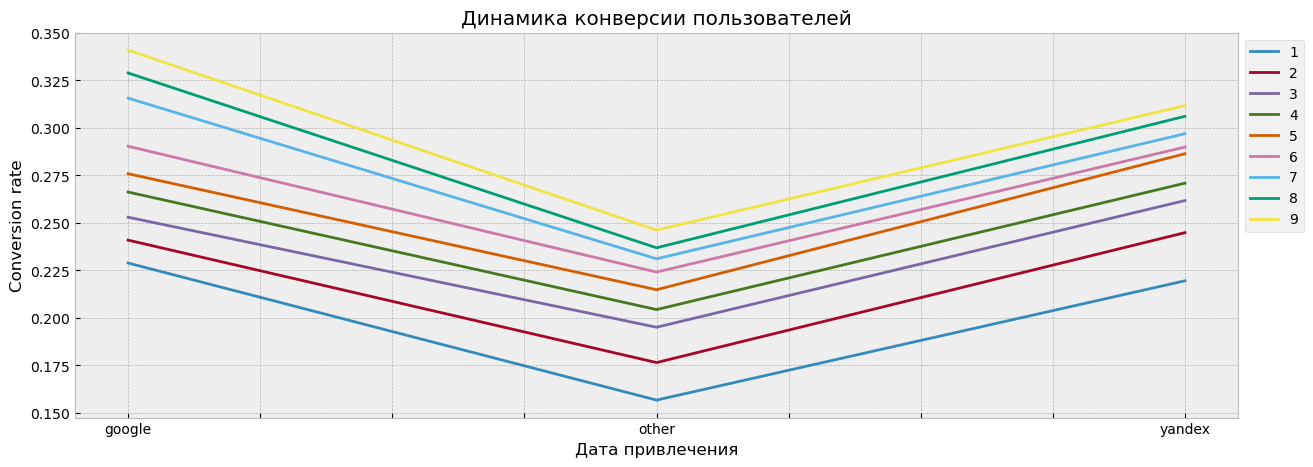

In [62]:
plots(conversion(events,dim='source',horizon_days=10),x='конверсии')

"Другие" источники сильно проседают по конверсии. Конверсия в первый день на 7% ниже. Возможно, люди случайно заходят в приложение.

Google и yandex идет бок о бок в лайфтаймах до 6 дней, после же google вырываеся вперед. Накопительно на 9 день у пользователей из google конверсия составила 34%, а у пользователей из yandex 31%. 

Так, целевым сегментом должны стать пользователи из поисковых систем, в частности - из google. Как вариант, стоит обратить внимание на улучшение положения сайта в поисковой выдаче (SEO).

Странно, что при большой дельте в конверсии между трафиком из поисковых систем и из других источников значительного различия в удержании  нет. То есть люди из "поисковых" источников покупают больше, но заходят в приложение так же часто, как и остальные пользовтели. При это сам retention rate довольно низкий: в первый день после 1-ого посещения прилоожения он уже падает до 14-16%. Возможно, стоит добавить пуш-уведомления для напоминания пользователям о приложении и/или о товарах, добавленных в корзину и тд.

 <a id="h5"></a> 
 ## Проверка гипотез

 <a id="h51"></a> 
 ### Влияние источника трафика на конверсию в просмотры контактов

In [63]:
conv=events[events['event_name']=='contacts_show'].groupby('source').agg({'user_id':'nunique'})
conv['cohort']=events.groupby('source').agg({'user_id':'nunique'})
conv.columns=['success','cohort']
conv

,success,cohort
source,,
google,275,1129
other,228,1230
yandex,478,1934


Проверим, значима ли статистически эта разница

H0: Конверсия в просмотр контактов в выборках одинаковая

H1: Конверсия в просмотр контактов в выборках различается

In [65]:
alpha = .05 #зададим уровень знасимость в 0.05
p_google = conv.loc['google','success']/ conv.loc['google','cohort']
p_yandex = conv.loc['yandex','success']/conv.loc['yandex','cohort']
p_other = conv.loc['other','success']/conv.loc['other','cohort']
# пропорция успехов в комбинированном датасете:
p_combined = (conv.loc['google','success'] + conv.loc['yandex','success']) / (conv.loc['google','cohort'] + conv.loc['yandex','cohort'])
#разница пропорций в датасетах difference = p1 - p2
difference = p_google - p_yandex
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/conv.loc['google','cohort']  + 1/conv.loc['yandex','cohort']))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
print(f'Конверсия пользователей из google {round(p_google*100)}%')
print(f'Конверсия пользователей из yandex {round(p_yandex*100)}%')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")



p-значение:  0.8244316027993777
Конверсия пользователей из google 24%
Конверсия пользователей из yandex 25%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ожидаемо, различия между conversion rate между пользователями из Google и из Yandex небольшие.

In [66]:
p_combined = (conv.loc['other','success'] + conv.loc['yandex','success']) / (conv.loc['other','cohort'] + conv.loc['yandex','cohort'])
difference = p_other - p_yandex
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/conv.loc['other','cohort']  + 1/conv.loc['yandex','cohort']))
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
print(f'Конверсия пользователей из других источников {round(p_other*100)}%')
print(f'Конверсия пользователей из yandex {round(p_yandex*100)}%')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


p-значение:  4.7142597613403225e-05
Конверсия пользователей из других источников 19%
Конверсия пользователей из yandex 25%
Отвергаем нулевую гипотезу: между долями есть значимая разница


Разница в конверсии пользователей из Яндекс и из других источников  статистически значима.

In [67]:
p_combined = (conv.loc['other','success'] + conv.loc['google','success']) / (conv.loc['other','cohort'] + conv.loc['google','cohort'])
difference = p_other - p_google
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/conv.loc['other','cohort']  + 1/conv.loc['google','cohort']))
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
print(f'Конверсия пользователей из других источников {round(p_other*100)}%')
print(f'Конверсия пользователей из google {round(p_google*100)}%')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")


p-значение:  0.0005640941887214979
Конверсия пользователей из других источников 19%
Конверсия пользователей из google 24%
Отвергаем нулевую гипотезу: между долями есть значимая разница


Разница в конверсии пользователей из Яндекс и из других источников  статистически значима.

 <a id="h52"></a> 
 ### Влияние повторного посещения приложения в течение 3 дней на конверсию в просмотры контактов

In [68]:
repeat=events[((events['event_dt']-events['first_dt']).dt.days<=3)]
n_sess=events.groupby('user_id').agg({'session':'nunique'}).reset_index()
repeat=repeat[repeat['user_id'].isin(n_sess[n_sess['session']>1]['user_id'].unique())]
len(repeat['user_id'].unique())

1920

In [69]:
non_repeat=events[~events['user_id'].isin(repeat['user_id'].unique())]
len(non_repeat['user_id'].unique())

2373

In [70]:
len(repeat[repeat['event_name']=='contacts_show']['user_id'].unique())/len(repeat['user_id'].unique())


0.26458333333333334

In [71]:
len(non_repeat[non_repeat['event_name']=='contacts_show']['user_id'].unique())/len(non_repeat['user_id'].unique())


0.15128529287821324

Проверим, значима ли статистически разница в конверсиях в показ контактов среди пользователей, которые вернулись в приложение в течение недели и нет

H0: Конверсия в просмотр контактов в выборках одинаковая

H1: Конверсия в просмотр контактов в выборках различается

In [72]:
conv_repeat=repeat[repeat['event_name']=='contacts_show'].agg({'user_id':'nunique'})
conv_repeat['cohort']=len(repeat['user_id'].unique())
conv_repeat

user_id     508
cohort     1920
dtype: int64

In [73]:
alpha = .05 #зададим уровень значимости в 0.05
p_repeat = len(repeat[repeat['event_name']=='contacts_show']['user_id'].unique())/len(repeat['user_id'].unique())
p_norepeat = len(non_repeat[non_repeat['event_name']=='contacts_show']['user_id'].unique())/len(non_repeat['user_id'].unique())

print(len(repeat['user_id'].unique()), len(non_repeat['user_id'].unique()))
# пропорция успехов в комбинированном датасете:
p_combined = (len(repeat[repeat['event_name']=='contacts_show']['user_id'].unique()) + len(non_repeat[non_repeat['event_name']=='contacts_show']['user_id'].unique()))/(len(repeat['user_id'].unique()) + len(non_repeat['user_id'].unique()))
#разница пропорций в датасетах difference = p1 - p2
difference = p_repeat - p_norepeat
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/len(repeat['user_id'].unique())   + 1/len(non_repeat['user_id'].unique())))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
print(f'Конверсия пользователей, повторно вернувшихся в приложение в течение 3 дней: {round(p_repeat*100)}%')
print(f'Конверсия пользователей, повторно не вернувшихся в приложение в течение 3 дней: {round(p_norepeat*100)}%')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")



1920 2373
p-значение:  0.0
Конверсия пользователей, повторно вернувшихся в приложение в течение 3 дней: 26%
Конверсия пользователей, повторно не вернувшихся в приложение в течение 3 дней: 15%
Отвергаем нулевую гипотезу: между долями есть значимая разница


Люди, которые заходят в приложение в течение 3 дней после первого посещения, чаще конвертируются в наше целевое действие - просмотр контактов. Разница статистически значима.

Это еще раз показывает, что идея с пуш уведомлениями хорошая. Впервые зашедшим пользователям нужно напоминать о существовании приложения в первые дни. Например, можно трекать, что искал в приложении пользователь и на страницы каких товары заходил, а после присылать уведомления о появлении новых товаров в этой категории или о появлении аналогов товаров, которые пользователь добавил в избранное.

 <a id="h6"></a> 
 ## Заключение

<div class="alert alert-info"> 
   В процессе анализа была проведена предобработка данных, которая не повлияла на размер выборки. Исходное качество данных было хорошее, что позволило провести анализ качественно.
    
Пользователи были разделены на сегменты в зависимости от источника трафика. Однозначного лидера по удержанию из них не обнаружено, но есть сильные различия по конверсии в целевое действие - просмотр контактов продавца. "Другие" источники сильно проседают по данному показателю: конверсия в первый день на 7% ниже. У пользователей из поисковых систем показатель заметно лучше: накопительно на 9 день у пользователей из google и yandex конверсия составила соответственно 34% и 31% против 25% у пользователей из других источников.

Поэтому целевым сегментом должны стать пользователи из поисковых систем, и в первую очередь стоит направить свои ресурсы на улучшение положения сайта в поисковой выдаче (SEO).

Также стоит обратить внимание на очень низкий (хоть и одинаковый) retention rate: в первый день после 1-ого посещения приложения удержание падает до 10-16%. Возможно, стоит добавить пуш-уведомления/почтовую рассылку для напоминания пользователям о приложении и/или о товарах, добавленных в корзину и тд.